# Learnable activation functions
**Name**: Enikő Palencsár \
**Neptune**: YD11NL \
**Course**: Geometric modelling and applications \
**Description**: Implement simple neural networks with different learnable activation functions, chosen from the approximation curves we learnt about in class. Observe their performance, strengths, weaknesses.

In [173]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary

## Class for a B-spline activation function
* Initialization of trainable parameters (control points)
* Knots uniformly distributed over $[0, 1]$ (could be trainable too, with monotonity condition)
* Forward pass definition
    * Scale inputs to be inside the interval $[u_{k-1}, u_{n+1}]$
    * Calculate the tensor of basis functions for the input as a matrix
    * Multiply each inner matrix with the corresponding knot value
    * Sum the corresponding elements of the resulting matrices, get a matrix with the input's dimensions
    * Be eternally happy

In [174]:
class BSplineActivation(nn.Module):
    def __init__(self, degree: int, control_point_num: int):
        super(BSplineActivation, self).__init__()
        self.degree = degree
        self.control_point_num = control_point_num
        # Randomize control points and make them learnable
        self.control_points = nn.Parameter(torch.randn(control_point_num))
        # Let the knots be uniformly distributed over the interval [0, 1]
        self.knots = torch.linspace(0, 1, control_point_num + degree + 1)

    def forward(self, x):
        # Scale the input into the interval of the knots
        x = self.scale_to_interval(x, self.knots[self.degree], self.knots[-self.degree-1])
        basis = self.basis_functions(x)
        sum_members = basis * self.control_points.view(10, 1, 1)
        result = torch.sum(sum_members, dim=0)
        return result

    def scale_to_interval(self, x, min_val, max_val):
        x_min, x_max = x.min(), x.max()
        x_scaled = min_val + (x - x_min) * (max_val - min_val) / (x_max - x_min)
        return x_scaled

    def basis_functions(self, x):
        k = self.degree
        # Store the i-th k-rank normalized B-spline bases for all elements of x
        basis = torch.zeros((self.control_point_num, x.shape[0], x.shape[1]))
        for i in range(0, self.control_point_num):
            basis[i] = self.basis_function(x, i, k)
        return basis

    def basis_function(self, x, i, k):
        if k == 1:
            return ((self.knots[i] <= x) & (x < self.knots[i+1])).float()
        else:
            coeff1 = (x - self.knots[i])/(self.knots[i+k-1]-self.knots[i])
            coeff2 = (self.knots[i + k] - x)/(self.knots[i+k]-self.knots[i+1])
            return coeff1 * self.basis_function(x, i, k-1) + coeff2 * self.basis_function(x, i+1, k-1)

### A simple test for the activation layer

In [175]:
linear = nn.Linear(1, 2)
activation = BSplineActivation(degree=3, control_point_num=10)
input = torch.linspace(0, 1, 5).unsqueeze(1)
x = linear(input)
x = activation(x)
input.shape, input, x.shape, x

(torch.Size([5, 1]),
 tensor([[0.0000],
         [0.2500],
         [0.5000],
         [0.7500],
         [1.0000]]),
 torch.Size([5, 2]),
 tensor([[-1.2263,  0.7070],
         [-0.9994,  1.0149],
         [-0.1687,  1.1365],
         [ 0.5014,  1.0720],
         [ 0.6455,  0.8212]], grad_fn=<SumBackward1>))

## A minimal network with learnable B-spline activation
Practically a simple B-spline approximation problem to be solved using backpropagation.

In [176]:
class BSplineNN(nn.Module):
    def __init__(self, degree, control_point_num):
        super(BSplineNN, self).__init__()
        self.input_layer = nn.Linear(1, 1)
        # self.hidden_layer = nn.Linear(64, 64)
        self.output_layer = nn.Linear(1, 1)
        self.activation = BSplineActivation(degree=degree, control_point_num=control_point_num)
    
    def forward(self, x):
        x = self.input_layer(x)
        x = self.activation(x)
        x = self.output_layer(x)
        return x

## Generation of synthetic training data (sine function)

In [177]:
x_train = torch.linspace(0, 1, 200).unsqueeze(1)
y_train = torch.sin(2 * np.pi * x_train)

## Training

In [178]:
# Initialize models
bspline_model = BSplineNN(degree=3, control_point_num=10)

# Optimizers
optimizer = optim.Adam(bspline_model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Training loop
epochs = 500
losses = []

for epoch in range(epochs):
    # Train B-Spline model
    bspline_model.train()
    optimizer.zero_grad()
    output_bspline = bspline_model(x_train)
    loss_bspline = loss_fn(output_bspline, y_train)
    loss_bspline.backward()
    optimizer.step()
    losses.append(loss_bspline.item())

    # Print loss occasionally
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss B-Spline: {loss_bspline.item():.4f}")

Epoch [50/500], Loss B-Spline: 0.1354
Epoch [100/500], Loss B-Spline: 0.0361
Epoch [150/500], Loss B-Spline: 0.0154
Epoch [200/500], Loss B-Spline: 0.0086
Epoch [250/500], Loss B-Spline: 0.0048
Epoch [300/500], Loss B-Spline: 0.0026
Epoch [350/500], Loss B-Spline: 0.0013
Epoch [400/500], Loss B-Spline: 0.0006
Epoch [450/500], Loss B-Spline: 0.0003
Epoch [500/500], Loss B-Spline: 0.0001


## Plot loss

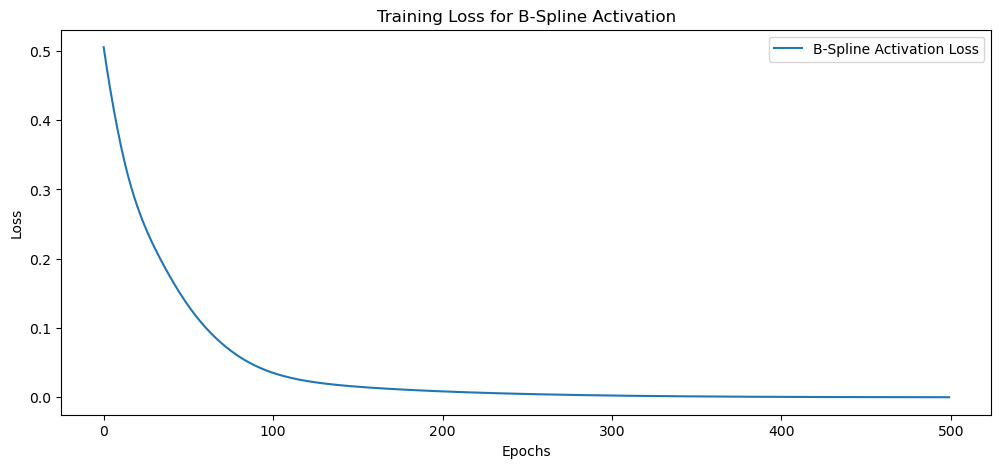

In [179]:
plt.figure(figsize=(12, 5))
plt.plot(losses, label='B-Spline Activation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss for B-Spline Activation')
plt.show()

## Visualize the trained activation function
Excellent example of how non-linearities work. The B-spline has the same shape as the original curve, but it's been shifted downwards. The leftover weights in the linear layers allow it to be transformed linearly without compromising the loss of the network. \
In a network with more neurons, more severe deformations will occur because of the different combinations of weights.

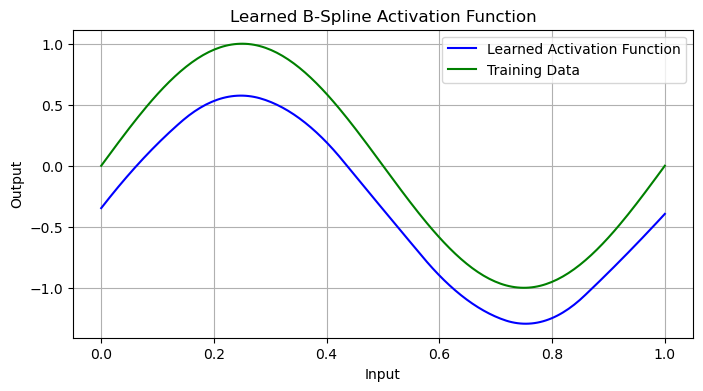

In [182]:
def visualize_activation(title, activation, x_train, y_train):
    with torch.no_grad():
        y = activation(x_train)
    
    plt.figure(figsize=(8, 4))
    
    # Plot the learned activation function
    plt.plot(x_train.numpy(), y.numpy(), label='Learned Activation Function', color='blue')
    
    # Plot the training data points
    plt.plot(x_train.numpy(), y_train.numpy(), label='Training Data', color='green')
    
    plt.title(title)
    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.grid(True)
    plt.legend()
    plt.show()

# Visualize Learned Activation
visualize_activation("Learned B-Spline Activation Function", bspline_model.activation, x_train, y_train)

## Inspect model structure

In [181]:
summary(bspline_model, input_size=[1,1])

Layer (type:depth-idx)                   Output Shape              Param #
BSplineNN                                [1, 1]                    --
├─Linear: 1-1                            [1, 1]                    2
├─BSplineActivation: 1-2                 [1, 1]                    10
├─Linear: 1-3                            [1, 1]                    2
Total params: 14
Trainable params: 14
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

### TODO

* Do we need weights if we have B-spline activation?
* Bezier activation, general NURBS activation
* Interpolating curves if time allows for them (oscillation will probably mess results up)
* Performance compared to ReLU (for same number of params)
* Performance in a more complex task e.g. image classification after CNN and flattening